In [1]:
import pygplates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
import os

%matplotlib inline

# PresentDay_LithData_Matthews2016_CEG_410-0Ma_ToAgeCorrected_CookCut_DeleteDataUsingStartAge
point_feature_filename = '/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/1_csv2shapefile/PresentDay_LithData_Matthews2016_410-0Ma/CEG/PresentDay_LithData_Matthews2016_CEG_410-0Ma_ToAgeCorrected_CookCut_DeleteDataUsingStartAge.shp'
input_feature_collection = pygplates.FeatureCollection(point_feature_filename)

#Rotation:Global_EB_410-0Ma_GK07_Matthews_etal_PMAG_fixed_crossovers.rot
input_rotation_filename_Matthews2016PMAG_fixed = ['/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/Rotations/Global_EB_410-0Ma_GK07_Matthews_etal_PMAG_fixed_crossovers.rot']

# empty rotation
#input_rotation_filename_Matthews2016PMAG_fixed = ['/Users/wenchaocao/Desktop/New_Rotation.rot']

rotation_model = pygplates.RotationModel(input_rotation_filename_Matthews2016PMAG_fixed)

In [2]:
def get_paleolithology(point_features,rotation_model):
    pX = []
    pY = []
    pAge = []
    for point in point_features:
        lithcode = point.get_shapefile_attribute('LithCode')
        #if lithcode == 'C' and point.get_reconstruction_plate_id()!=0:
        #if lithcode == 'E' and point.get_reconstruction_plate_id()!=0:
        if lithcode== 'T' or lithcode=='D' or lithcode=='G' and point.get_reconstruction_plate_id()!=0:
            BirthTime = np.median(point.get_valid_time())
            if BirthTime<410:
                pAge.append(BirthTime)
                point_rotation = rotation_model.get_rotation(BirthTime, point.get_reconstruction_plate_id(), anchor_plate_id=0) #obtain rotating rules
                reconstructed_point = point_rotation * point.get_geometry() # carry out reconstruction
                pX.append(reconstructed_point.to_lat_lon()[1])
                pY.append(reconstructed_point.to_lat_lon()[0])            
    return pX,pY,pAge

In [3]:
age_range_list = [(419,393),   # Early Devonian
           (393,388),   # Middle Devonian (Eifelian)
           (388,383),   # Middle Devonian (Givetian)
           (383,359),   # Late Devonian
           (359,331),   # Early Carboniferous (Tournaisian-Visean)
           (331,323),   # Early Carboniferous (Serpukhovian)
           (323,307),   # Late Carboniferous (Bashkirian-Moscovian)
           (307,299),   # Late Carboniferous (Kasimovian-Gzhelian)
           (299,290),   # Early Permian (Asselian-Sakmarian)
           (290,252),   # Middle-Late Permian (Artinskian-Lopingian)
           (252,247),   # Early Triassic
           (247,237),   # Middle Triassic
           (237,201),   # Late Triassic
           (201,164),   # Early and Middle Jurassic
           (164,145),   # Late Jurassic
           (145,113),   # Early Cretaceous (Berriasian-Aptian)
           (113,89.8),   # Late Cretaceous (Albian-Turonian)
           (89.8,66.0),   # Late Cretaceous (Coniacian-Maastrichtian)
           (66.0,56.0),   # Paleocene
           (56.0,47.8),  # Early Eocene (Ypresian?)
           (47.8,33.9),  # Middle and Late Eocene
           (33.9,23.0),  # Oligocene
           (23.0,5.3),    # Miocene
           (0.01,-0.01)] # present-day
#print age_range_list[5:]

i = 0
for i in np.arange(0,24,1):
    Age = np.mean(age_range_list[i])
    print Age

406.0
390.5
385.5
371.0
345.0
327.0
315.0
303.0
294.5
271.0
249.5
242.0
219.0
182.5
154.5
129.0
101.4
77.9
61.0
51.9
40.85
28.45
14.15
0.0


In [4]:
# reconstruct all data and get their x, y coordinates and ages
pX,pY,pAge = get_paleolithology(input_feature_collection,rotation_model)
#print len(pX)
#print pAge


for j in np.arange(0,24,1):
    n = 0
    for i in np.arange(0,len(pAge),1):
        if np.array(pAge[i]) == np.mean(age_range_list[j]):
            n = n+1
            #print np.array(pAge[i])
            #print np.mean(age_range_list[j])
    print n

0
0
0
6
5
1
9
5
72
11
0
0
0
5
6
11
0
1
2
1
2
9
17
228


In [5]:
# remove the sampling bias

result_original = []
result_SamplingBiasRemoved = []
result_flipped = []
result_doubled = []

for i in np.arange(0,24,1):
    
    result = []
    result_0 = []
    result_1 = []
    result_2 = []
    result_3 = []
    
    index = np.where(np.array(pAge) == np.mean(age_range_list[i]))
    #print np.mean(age_range_list[i]),np.array(pAge)[index]
    
    xedges = np.arange(-180, 181, 5) #180, longtitude
    yedges = np.arange(-90, 91, 5) #90, latitude, specify the bin size
    data_hist = np.histogram2d(np.array(pX)[index],np.array(pY)[index], bins=(xedges, yedges))
    result_0 = np.nansum(data_hist[0], axis=0)
    result_original.append(result_0)
    #print type(result_original)
    
    # save the original data
    #df = pd.DataFrame(data_hist[0].T)
    #writer = pd.ExcelWriter('OriginalData_Glacial_%sMa.xlsx' % np.mean(age_range_list[i]), engine='xlsxwriter') # Evaporite
    #df.to_excel(writer, sheet_name='Sheet1')
    #writer.save()
    
    # remove the sampling bias
    result_1 = np.nansum(data_hist[0]/data_hist[0], axis=0)
    #print result_1
    result_SamplingBiasRemoved.append(result_1)
    
    #plt.pcolor(xedges,yedges,data_hist[0].T) #T means reverse the x, y axis
    
    # flip the data
    result_2 = np.flipud(result_1[:18])+result_1[18:]
    result_flipped.append(result_2) # add data on south hemisphere to north hemishpere
    #print result_flipped
    
    # double the data
    result_3 = list(np.flipud(result_2)) + list(result_2) 
    result_doubled.append(np.array(result_3)) # add data on south hemisphere to north hemishpere
    #print result_doubled

# save data for all time steps into a table
#df = pd.DataFrame(result_original)
#writer = pd.ExcelWriter('Glacial_Origianl_410-0Ma.xlsx' % np.mean(age_range_list[i]), engine='xlsxwriter')
#df.to_excel(writer, sheet_name='Sheet1')
#writer.save()

# save sampling bias-corrected data for all time steps into a table
#df = pd.DataFrame(result_SamplingBiasRemoved)
#writer = pd.ExcelWriter('Glacial_SamplingBiasCorrected_410-0Ma.xlsx' % np.mean(age_range_list[i]), engine='xlsxwriter')
#df.to_excel(writer, sheet_name='Sheet1')
#writer.save()

# save flipped data for all time steps into a table
#df = pd.DataFrame(result_flipped)
#writer = pd.ExcelWriter('Glacial_Flipped_410-0Ma.xlsx' % np.mean(age_range_list[i]), engine='xlsxwriter')
#df.to_excel(writer, sheet_name='Sheet1')
#writer.save()

# save flipped data for all time steps into a table
#df = pd.DataFrame(result_doubled)
#writer = pd.ExcelWriter('Glacial_Doubled_410-0Ma.xlsx' % np.mean(age_range_list[i]), engine='xlsxwriter')
#df.to_excel(writer, sheet_name='Sheet1')
#writer.save()

#result_1 = []
#result_1 = np.sum(result,axis=0) # sum up data in Y-axis


/Users/wenchaocao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in divide


/Users/wenchaocao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in divide


<function matplotlib.pyplot.show>

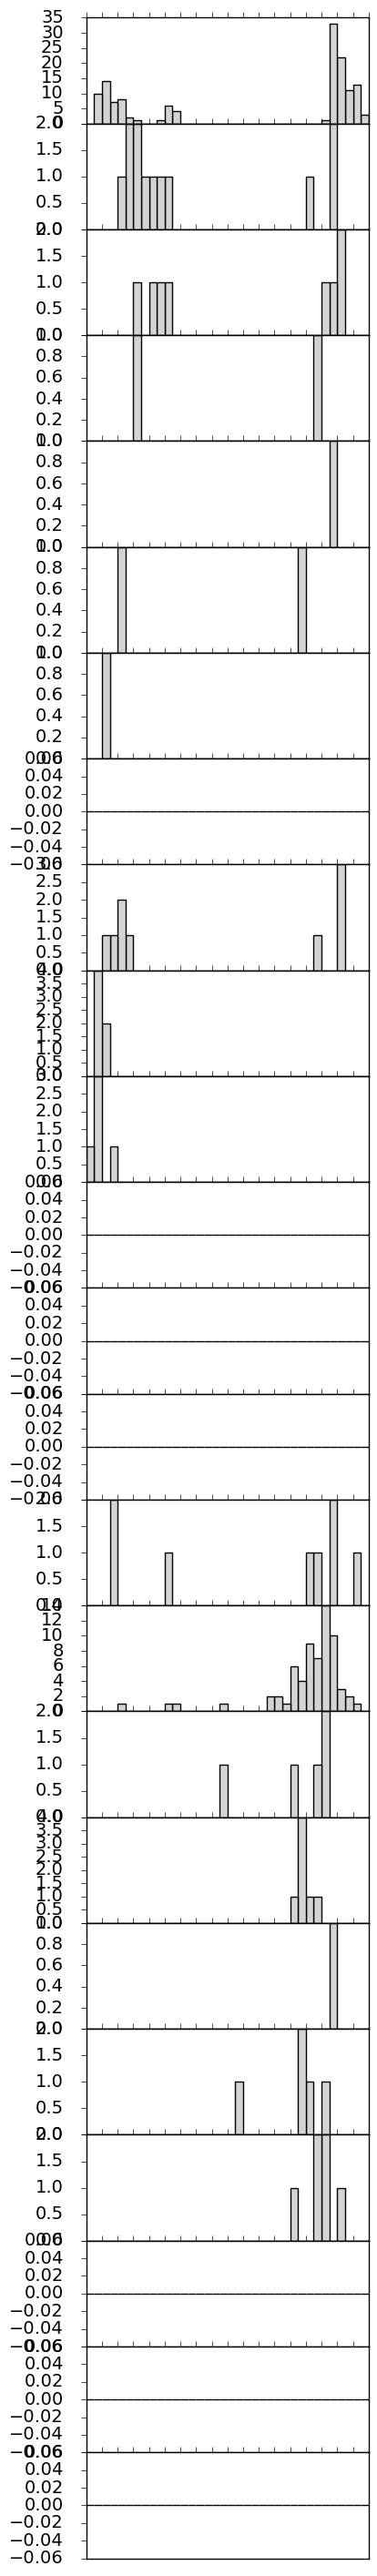

In [6]:
fig, axes = plt.subplots(nrows=24, ncols=1,figsize=(4, 36)) 

for i in np.arange(0,24,1):
    
    result = []
    
    index = np.where(np.array(pAge) == np.mean(age_range_list[23-i]))
    #print np.mean(age_range_list[i]),np.array(pAge)[index]
    
    xedges = np.arange(-180, 181, 5) #longtitude
    yedges = np.arange(-90, 91, 5) #latitude, specify the bin size
    data_hist = np.histogram2d(np.array(pX)[index],np.array(pY)[index], bins=(xedges, yedges))
    
    # plot original data
    result_0 = np.nansum(data_hist[0], axis=0)
    #axes[i].bar(np.array(yedges[:-1]), result_0, width=5, color='lightgrey') #,alpha=0.4
    
    # plot data sampling bias corrected
    result_1 = np.nansum(data_hist[0]/data_hist[0], axis=0)
    axes[i].bar(np.array(yedges[:-1]), result_1, width=5, color='lightgrey') #,alpha=0.4
    
    # flipped data
    #result_2 = np.flipud(result_1[:18])+result_1[18:]
    
    # double the data
    #result_3 = list(np.flipud(result_2)) + list(result_2)
    #axes[i].bar(np.array(yedges[:-1]), result_3, width=5, color='blue',alpha=0.4)
    
    axes[i].set_xticks(np.arange(-90, 91, 10))
    axes[i].set_xticklabels([])
    axes[i].set_xlim((90,-90))
    axes[i].xaxis.set_tick_params(direction='out') #labelsize=12,
    #plt.setp(axes[i].get_xticklabels(), fontsize=12.) #,rotation=50

    axes[i].yaxis.set_tick_params(labelsize=14,direction='out') #
    axes[i].xaxis.set_ticks_position('top') # bottom
    axes[i].yaxis.set_ticks_position('left')
    
    # set labels
    #axes[i].set_ylabel('Number of data points',fontsize=16)
    #axes[i].set_xlabel('Latitude [degree]',fontsize=16)
    #axes[i].set_ylim((0,40))
    #axes[i].set_ylim((0,10)) # evaporites
    #axes.set_ylim((0,4)) # evaporites

fig.subplots_adjust(hspace=0.00)
#plt.savefig('Glacial_Matthews2016_SamplingBiasCorrected.pdf',dpi=600)
plt.show



## Or: the codes below

In [ ]:
fig, axes = plt.subplots(nrows=24, ncols=1,figsize=(4, 36))

for i in np.arange(0,24,1):
    
    result = []
    
    index = np.where(np.array(pAge) == np.mean(age_range_list[i]))
    #print np.mean(age_range_list[i]),np.array(pAge)[index]
    
    xedges = np.arange(-180, 181, 5) #longtitude
    yedges = np.arange(-90, 91, 5) #latitude, specify the bin size
    data_hist = np.histogram2d(np.array(pX)[index],np.array(pY)[index], bins=(xedges, yedges))
    
    # plot original data
    result_0 = np.nansum(data_hist[0], axis=0)
    #axes[i].bar(np.array(yedges[:-1]), result_0, width=5, color='blue',alpha=0.4)
    
    # plot data sampling bias corrected
    result_1 = np.nansum(data_hist[0]/data_hist[0], axis=0)
    #axes[i].bar(np.array(yedges[:-1]), result_1, width=5, color='blue',alpha=0.4)
    
    # flipped data
    result_2 = np.flipud(result_1[:18])+result_1[18:]
    
    # double the data
    result_3 = list(np.flipud(result_2)) + list(result_2)
    axes[23-i].bar(np.array(yedges[:-1]), result_3, width=5, color='lightgrey',linewidth=0.5) #,alpha=0.4,edgecolor='grey',
    
    axes[23-i].set_xticks(np.arange(-90, 91, 10))
    axes[23-i].set_xticklabels([])
    axes[23-i].set_xlim((90,-90))
    axes[23-i].set_ylim(ymin=0)
    axes[23-i].xaxis.set_tick_params(direction='out') #labelsize=12,
    #plt.setp(axes[i].get_xticklabels(), fontsize=12.) #,rotation=50

    axes[23-i].yaxis.set_tick_params(labelsize=14,direction='out') #
    axes[23-i].xaxis.set_ticks_position('top') # bottom
    axes[23-i].set_yticks(axes[23-i].get_yticks()[::2]) # set the major ticks
    interval = np.diff(axes[23-i].get_yticks())[0]
    axes[23-i].yaxis.set_minor_locator(MultipleLocator(interval/2))
    axes[23-i].tick_params(which = 'both', direction = 'out') # if only want to set y-axis: axes[1,2].yaxis.set_tick_params(labelsize=12,direction='out')
    axes[23-i].yaxis.set_ticks_position('left')

fig.subplots_adjust(hspace=0.00)
#plt.savefig('Glacial_Doubled_Matthews2016_BinSize5.pdf',dpi=600)
plt.show



### Plot the peaks

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

data_coals = []
sencond_largest = []
data_coals_second = []
for i in np.arange(0,24,1):  #(40,211,50),np.arange(0,401,50)
    
    #fig, axes = plt.subplots(figsize=(8,6))  #nrows=24, ncols=1,
    yedges = np.arange(-90, 91, 5) #latitude
    
    #####################################################################
    # Plot SiZer curves
    
    # Coals
    #data_coal_sizer = pd.read_table('/Users/wenchaocao/Research/33_MatLab/Library/Feature_modified/Smoothing/Coals_Matthews2016_TwoBiasRemoved_CorrectedBeforeFlipping_Doubled/'+str(i)+'/Data_XY_BestFitting.txt',header=None, delimiter=r"\s+")
    #data_array = np.array(data_coal_sizer)
    
    # Evaporites
    #data_coal_sizer = pd.read_table('/Users/wenchaocao/Research/33_MatLab/Library/Feature_modified/Smoothing/Evaporites_Matthews2016_TwoBiasRemoved_CorrectedBeforeFlipping_Doubled/'+str(i)+'/Data_XY_BestFitting.txt',header=None, delimiter=r"\s+")
    #data_array = np.array(data_coal_sizer)
    
    # Glacial deposits
        # Glacial
    data_sizer = '/Users/wenchaocao/Research/33_MatLab/Library/Feature_modified/Smoothing/Glacial_Matthews2016_TwoBiasRemoved_CorrectedBeforeFlipping_Doubled/'+str(i)+'/Data_XY_BestFitting.txt'
    if os.path.isfile(data_sizer):

        data_coal_sizer = pd.read_table('/Users/wenchaocao/Research/33_MatLab/Library/Feature_modified/Smoothing/Glacial_Matthews2016_TwoBiasRemoved_CorrectedBeforeFlipping_Doubled/'+str(i)+'/Data_XY_BestFitting.txt',header=None, delimiter=r"\s+")
        data_array = np.array(data_coal_sizer)

    
        #print np.max(data_array[:,1])
        #print np.max(data_array[:len(data_array)/2,1])
        index = np.where(data_array[:len(data_array)/2+1,1] == np.max(data_array[:len(data_array)/2+1,1]))
        data_coals.append(data_array[:,0][index]*-1)
    else:
        data_coals.append(0)
print data_coals
    
    # find second largest value
    #index_second = np.where(data_array[:len(data_array)/2,1] == sorted(data_array[:len(data_array)/2,1])[-2])
    #print index_second
    #data_coals_second.append(data_array[:,0][index_second]*-1)

    
    #print np.max(data_coal_sizer)
    #axes[23-i].plot(data_coal_sizer.iloc[:,0],data_coal_sizer.iloc[:,1],'black',linewidth=2.0)
    
    # Evaporites
    #data_coal_sizer = pd.read_table('/Users/wenchaocao/Research/33_MatLab/Library/Feature_modified/Smoothing/Evaporites_Matthews2016_TwoBiasRemoved_CorrectedBeforeFlipping_Doubled/'+str(i)+'/Data_XY_BestFitting.txt',header=None, delimiter=r"\s+")
    #axes[23-i].plot(data_coal_sizer.iloc[:,0],data_coal_sizer.iloc[:,1],'black',linewidth=2.0)
    
    # Glacial
    #data_sizer = '/Users/wenchaocao/Research/33_MatLab/Library/Feature_modified/Smoothing/Glacial_Matthews2016_TwoBiasRemoved_CorrectedBeforeFlipping_Doubled/'+str(i)+'/Data_XY_BestFitting.txt'
    #if os.path.isfile(data_sizer):
    #    data_coal_sizer = pd.read_table('/Users/wenchaocao/Research/33_MatLab/Library/Feature_modified/Smoothing/Glacial_Matthews2016_TwoBiasRemoved_CorrectedBeforeFlipping_Doubled/'+str(i)+'/Data_XY_BestFitting.txt',header=None, delimiter=r"\s+")
    #    axes[23-i].plot(data_coal_sizer.iloc[:,0],data_coal_sizer.iloc[:,1],'black',linewidth=2.0)
    #else:
    #    print "No data"
    #####################################################################

In [ ]:
      
fig, axes = plt.subplots(figsize=(8,6))  #nrows=24, ncols=1,
print (data_coals)

Data = pd.read_excel('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/2_2_Sum_LithData_Matthews2016_EachMap_410-0Ma/Sum_LithData_Matthews2106_EachMap_410-0Ma.xlsx')

# create an array to install FromAge and ToAge at the same time
time = np.zeros(len(Data['FromAge'])*2)
time[::2] = Data['FromAge']
time[1::2] = Data['ToAge']
print time

data_coals_1 = np.zeros(len(data_coals)*2)
data_coals_1[::2] = data_coals
data_coals_1[1::2] = data_coals
print data_coals_1

data_coals_2 = np.zeros(len(data_coals_second)*2)
data_coals_2[::2] = data_coals_second
data_coals_2[1::2] = data_coals_second
print data_coals_2

#plt.scatter(np.arange(0,24,1),data)
plt.plot(time,data_coals_1)

plt.plot(time,data_coals_2)

axes.set_xticks(np.hstack((Data['FromAge'],Data['ToAge'])))
#axes.set_xticks(np.arange(0, 24, 1))
#axes.set_xticklabels([])
axes.set_xlim((419,0))
axes.xaxis.set_tick_params(direction='out')
axes.yaxis.set_tick_params(labelsize=14,direction='out')
axes.xaxis.set_ticks_position('bottom')
axes.yaxis.set_ticks_position('left')

#plt.savefig('Glacial_Matthews2016_SiZer.pdf')
#plt.show()
                     

## Plot present-day figure

In [ ]:
fig, axes = plt.subplots(figsize=(8, 3)) 

for i in np.arange(23,24,1):
    
    result = []
    
    index = np.where(np.array(pAge) == np.mean(age_range_list[i]))
    #print np.mean(age_range_list[i]),np.array(pAge)[index]
    
    xedges = np.arange(-180, 181, 5) #longtitude
    yedges = np.arange(-90, 91, 5) #latitude, specify the bin size
    data_hist = np.histogram2d(np.array(pX)[index],np.array(pY)[index], bins=(xedges, yedges))
    
    # plot original data
    result_0 = np.nansum(data_hist[0], axis=0)
    #axes.bar(np.array(yedges[:-1]), result_0, width=5, color='lightgrey') #,alpha=0.4
    
    # plot data sampling bias corrected
    result_1 = np.nansum(data_hist[0]/data_hist[0], axis=0)
    #axes.bar(np.array(yedges[:-1]), result_1, width=5, color='lightgrey') #,alpha=0.4
    
    # flipped data
    result_2 = np.flipud(result_1[:18])+result_1[18:]
    
    # double the data
    result_3 = list(np.flipud(result_2)) + list(result_2)
    #axes[i].bar(np.array(yedges[:-1]), result_3, width=5, color='blue',alpha=0.4)
    
    axes.set_xticks(np.arange(-90, 91, 10))
    #axes.set_xticklabels()
    axes.set_xlim((90,-90))
    axes.xaxis.set_tick_params(labelsize=12,direction='out')
    plt.setp(axes.get_xticklabels(), fontsize=12.) #,rotation=50

    
    axes.yaxis.set_tick_params(labelsize=12,direction='out')
    axes.xaxis.set_ticks_position('bottom')
    axes.yaxis.set_ticks_position('left')
    # set labels
    axes.set_ylabel('Number of data points',fontsize=16)
    axes.set_xlabel('Latitude [degree]',fontsize=16)
    #axes[i].set_ylim((0,40))
    #axes[i].set_ylim((0,10)) # evaporites
    #axes.set_ylim((0,4)) # evaporites

#fig.subplots_adjust(hspace=0.01)
plt.savefig('Coals_Matthews2016_SamplingBiasCorrected.pdf',dpi=600)
plt.show



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# plot land area
data_coal_raw = pd.read_excel('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/6_LandArea_InEachBand_InEachMap/1_LandArea_InEachBand_Matthews2016Modified_EachMap.xlsx')
data_coal = np.array(data_coal_raw)
#print np.sum(data_coal[23,:])
#print np.float64(data_coal[23,:])/np.sum(data_coal[23,:])

# data two bias removed before flipping
#data_coal_raw = pd.read_excel('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/9_1_LithData_TwoBiasRemoved_CorrectedBeforeFlipping/Coals_Matthews2016_TwoBiasRemoved_CorrectedBeforeFlipping.xlsx')
#data_coal = np.array(data_coal_raw)
#print data_coal[:,23]

# 9_2_LithData_TwoBiasRemoved_CorrectedBeforeFlipping_Flipped
#data_coal_raw = pd.read_excel('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/9_2_LithData_TwoBiasRemoved_CorrectedBeforeFlipping_Flipped/Coals_TwoBiasRemoved_CorrectedBeforeFlipping_Flipped.xlsx')
#data_coal = np.array(data_coal_raw)
#print data_coal[:,23]

# 9_3_LithData_TwoBiasRemoved_CorrectedBeforeFlipping_Doubled
#data_coal_raw = pd.read_excel('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/9_3_LithData_TwoBiasRemoved_CorrectedBeforeFlipping_Doubled/Coals_TwoBiasRemoved_CorrectedBeforeFlipping_Flipped_Doubled.xlsx')
#data_coal = np.array(data_coal_raw)
#print data_coal[:,23]


IOError: [Errno 2] No such file or directory: '/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/6_LandArea_InEachBand_InEachMap/1_LandArea_InEachBand_Matthews2016Modified_EachMap.xlsx'

[-90 -85 -80 -75 -70 -65 -60 -55 -50 -45 -40 -35 -30 -25 -20 -15 -10  -5
   0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90]


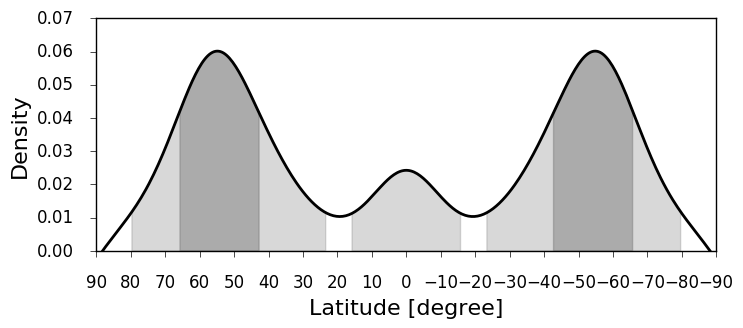

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

fig,axes = plt.subplots(figsize=(8,3)) #,tight_layout=True

for i in np.arange(23,24,1):  #(40,211,50),np.arange(0,401,50)
    #ax = plt.subplot(1,24,i+1)
    yedges = np.arange(-90, 91, 5) #latitude
    print yedges
    #print data_coal[:,23]
    
    # plot data two bias removed before flipping
    #plt.bar(yedges[:-1], np.float64(data_coal[:,23]/np.sum(data_coal[:,23])), width=5, color='lightgrey')
    
    # area of each strip
    #plt.bar(yedges[:-1], np.float64(data_coal[23,:])/np.sum(data_coal[23,:])*100, width=5, color='lightgrey')
    
    # data points
    #plt.bar(yedges[:-1], np.float64(data_coal[:,23]/np.sum(data_coal[:,23])), width=5, color='lightgrey')
    
    # plot data after flipped
    #print yedges[18:-1]
    #plt.bar(yedges[18:-1], np.float64(data_coal[:,23]/np.sum(data_coal[:,23])), width=5, color='lightgrey')
    
    # data after doubled
    #axes.bar(yedges[:-1], np.float64(data_coal[:,23]/np.sum(data_coal[:,23])), width=5, color='lightgrey')
    

    #####################################################################
    # SiZer
    data_coal_sizer = pd.read_table('/Users/wenchaocao/Research/33_MatLab/Library/Feature_modified/Smoothing/9_3_LithData_TwoBiasRemoved_CorrectedBeforeFlipping_Doubled_BinningSize5_Normalised/Coals_Matthews2016_TwoBiasRemoved_CorrectedBeforeFlipping_Doubled_BinningSize5_Normalised/Data_XY_BestFitting_'+str(i)+'.txt',header=None, delimiter=r"\s+")
    axes.plot(data_coal_sizer.iloc[:,0],data_coal_sizer.iloc[:,1],'black',linewidth=2.0)
    
    
    # HDR
    data_raw_hdr = pd.read_csv('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/HDR/Coals_Matthews2016_TwoBiasRemoved_CorrectedBeforeFlipping_Flipped_Doubled_BinningSize5_Normalised/hdr_'+str(i)+'.csv')
    data_hdr = np.array(data_raw_hdr)
    boundary_50CI_1 = data_hdr[2,1]
    boundary_95CI_1 = data_hdr[0,1]

    y_50 = np.interp(boundary_50CI_1, data_coal_sizer.iloc[:,0], data_coal_sizer.iloc[:,1])
    #y_75 = np.interp(-73.29, data_coal_sizer.iloc[:,0], data_coal_sizer.iloc[:,1])
    y_95 = np.interp(boundary_95CI_1, data_coal_sizer.iloc[:,0], data_coal_sizer.iloc[:,1])
    
    # filled
    axes.fill_between(data_coal_sizer.iloc[:,0],data_coal_sizer.iloc[:,1],where=data_coal_sizer.iloc[:,1] > y_95,color='grey',alpha=0.3) #linewidth=2.0,
    #axes.fill_between(data_coal_sizer.iloc[:,0],data_coal_sizer.iloc[:,1],where=data_coal_sizer.iloc[:,1] > y_75,color='grey',alpha=0.4) #linewidth=2.0,
    axes.fill_between(data_coal_sizer.iloc[:,0],data_coal_sizer.iloc[:,1],where=data_coal_sizer.iloc[:,1] > y_50,color='grey',alpha=0.5) #linewidth=.0,

    axes.set_ylim(ymin=0)
    axes.set_xticks(np.arange(-90, 91, 10))
    axes.set_xlim((90,-90))
    axes.xaxis.set_tick_params(labelsize=12,direction='out')
    plt.setp(axes.get_xticklabels(), fontsize=12.) #,rotation=50

    axes.yaxis.set_tick_params(labelsize=12,direction='out')
    axes.xaxis.set_ticks_position('bottom')
    axes.yaxis.set_ticks_position('left')
    # set labels
    axes.set_ylabel('Density',fontsize=16)
    axes.set_xlabel('Latitude [degree]',fontsize=16)

    ymax= np.interp(boundary_50CI_1, data_coal_sizer.iloc[:,0], data_coal_sizer.iloc[:,1])

#plt.savefig('Sizer_Coals_Matthews2016_Doubled_PresentDay.pdf')
plt.show()

0.0398463906367
0.0398069052718


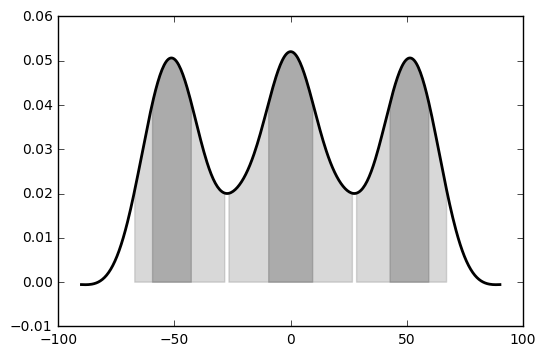

In [46]:

figure, axes = plt.subplots()
# HDR
i=8
data_raw_hdr = pd.read_csv('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/HDR/Coals_Matthews2016_TwoBiasRemoved_CorrectedBeforeFlipping_Flipped_Doubled_BinningSize5_Normalised/hdr_'+str(i)+'.csv')
data_hdr = np.array(data_raw_hdr)
boundary_50CI_1 = data_hdr[2,1]
boundary_75CI_1 = data_hdr[1,1]
boundary_95CI_1 = data_hdr[0,1]

data_coal_sizer = pd.read_table('/Users/wenchaocao/Research/33_MatLab/Library/Feature_modified/Smoothing/9_3_LithData_TwoBiasRemoved_CorrectedBeforeFlipping_Doubled_BinningSize5_Normalised/Coals_Matthews2016_TwoBiasRemoved_CorrectedBeforeFlipping_Doubled_BinningSize5_Normalised/Data_XY_BestFitting_'+str(i)+'.txt',header=None, delimiter=r"\s+")
axes.plot(data_coal_sizer.iloc[:,0],data_coal_sizer.iloc[:,1],'black',linewidth=2.0)

y_50 = np.interp(boundary_50CI_1, data_coal_sizer.iloc[:,0], data_coal_sizer.iloc[:,1])
print y_50
y_test = np.interp(, data_coal_sizer.iloc[:,0], data_coal_sizer.iloc[:,1])
print y_test

#print y_50
#y_75 = np.interp(boundary_75CI_1, data_coal_sizer.iloc[:,0], data_coal_sizer.iloc[:,1])
y_95 = np.interp(boundary_95CI_1, data_coal_sizer.iloc[:,0], data_coal_sizer.iloc[:,1])
#print y_95


axes.fill_between(data_coal_sizer.iloc[:,0],data_coal_sizer.iloc[:,1],where=data_coal_sizer.iloc[:,1] > y_95,color='grey',alpha=0.3) #linewidth=2.0,
#axes.fill_between(data_coal_sizer.iloc[:,0],data_coal_sizer.iloc[:,1],where=data_coal_sizer.iloc[:,1] > y_75,color='grey',alpha=0.4) #linewidth=2.0,
axes.fill_between(data_coal_sizer.iloc[:,0],data_coal_sizer.iloc[:,1],where=data_coal_sizer.iloc[:,1] > y_50,color='grey',alpha=0.5) #linewidth=.0,


In [ ]:
#colors = ['c', 'r', 'b', 'g', ]
#colors = colors + list(reversed(colors))

#for i, color in zip(range(-4, 4), colors):
low = np.interp(43, data_coal_sizer.iloc[:,0], data_coal_sizer.iloc[:,1])
high = np.interp(70, data_coal_sizer.iloc[:,0], data_coal_sizer.iloc[:,1])

px = x[np.logical_and(x >= 43, x <= 70) | np.logical_and(x >= -70, x <= -43)]
print len(px)
py = y[np.logical_and(y >= low, y <= high)]
print len(py)
plt.fill_between(x,y,where=x > 43,linewidth=2.0,color='k')